---
## Project DARNA: **D**etection of **A**nomaly in OFW **R**ecruitment Posts thru Recurrent **N**eur**A**l Network
----
###***Capstone Completion Project Submitted by Christian D. Laurio***

Recurrent Neural Networks (RNNs) for tagging OFW Recruitment Posts     
Problem - Classify whether Job Recruitements Posts Online as Risky or Not   
In this project, we will use Recurrent Neural Networks to achieve it.

We will follow these steps:

Reading the dataset

1.   Exploratory data analysis
2.   Train-validation dataset split
1.   Text processing and transformation
2.   Using GloVe Word Embeddings
1.   Training and validating model
---






In [1]:
%pip install -q -r /content/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/requirements.txt'


In [2]:
!pip install mxnet
import re
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn, rnn, Trainer
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss 
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# 1. Read the dataset

> Let's read the dataset below and fill-in the reviewText field. We will use this field as input to our ML model.



In [3]:
import pandas as pd

path='https://raw.githubusercontent.com/Atom0890/Project-DARNA/main/Final_DARNA_Dataset.csv'
df=pd.read_csv(path)

In [4]:
df.head(5)

,Post,Risky?
0,Urgent!!!!!!\nWe’re looking for 2 caregiver st...,1
1,*Looking for Passport Holder bound to Singapor...,1
2,URGENT - URGENT!!!\nBARTENDER\nImmediate Joini...,1
3,## **Job Opportunity in Australia**\n\nWe are ...,1
4,Sino po walang pang gastos dito na gustong mag...,1


In [5]:
df.tail()

,Post,Risky?
243,SAUDI ARABIA 1010 EPHESIANS HUMAN RESOURCES IN...,0
244,SAUDI ARABIA 1010 EPHESIANS HUMAN RESOURCES IN...,0
245,SAUDI ARABIA 1010 EPHESIANS HUMAN RESOURCES IN...,0
246,"JJ Offshore Services, Inc.\n2nd floor & 3rd fl...",0
247,-PERMISSI0N T0 P0ST ADMIN-\n>-URGENT HIRING-<\...,0


# 2. Exploratory Data Analysis

> Let's look at the distribution and range of Risky? posts



In [6]:
df["Risky?"].value_counts()

0    133
1    115
Name: Risky?, dtype: int64

> Check for the missing values

In [7]:
print(df.isna().sum())

Post      0
Risky?    0
dtype: int64


# 3. Train-Validation Split
> Let's split the data into training and validation sets

In [8]:
# This separates 10% of the entire dataset into validation dataset.
train_text, val_text, train_label, val_label = \
    train_test_split(df["Post"].tolist(),
                     df["Risky?"].tolist(),
                     test_size=0.10,
                     shuffle=True,
                     random_state=324)

# 4. Text Processing and Transformation
>We will apply the following processes here:


*   **Text cleaning:** Simple text cleaning operations. We won't do stemming or lemmatization as our word vectors already cover different forms of words. We are using GloVe word embeddings for 6 billion words, phrases or punctuations in this example.
*   **Tokenization:** Tokenizing all sentences
*   **Creating vocabulary:** We will create a vocabulary of the tokens. In this vocabulary, tokens will map to unique ids
*   **Transforming text:** Tokenized sentences will be mapped to unique ids







In [9]:
!pip install gluonnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=926ec4a6149ae00b98bcc5e14d9e452d8c3d72ef68472d87b2a85711b873bb7b
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [10]:
import nltk, gluonnlp
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def cleanStr(text):
    
    # Check if the sentence is a missing value
    if isinstance(text, str) == False:
        text = ""
            
    # Remove leading/trailing whitespace
    text = text.lower().strip()
    # Remove extra space and tabs
    text = re.sub('\s+', ' ', text)
    # Remove HTML tags/markups
    text = re.compile('<.*?>').sub('', text)
    return text

def tokenize(text):
    tokens = []
    text = cleanStr(text)
    words = word_tokenize(text)
    for word in words:
        tokens.append(word)
    return tokens

def createVocabulary(text_list, min_freq):
    all_tokens = []
    for sentence in text_list:
        all_tokens += tokenize(sentence)
    # Calculate token frequencies
    counter = gluonnlp.data.count_tokens(all_tokens)
    # Create the vocabulary
    vocab = gluonnlp.Vocab(counter,
                           min_freq = min_freq,
                           unknown_token = '<unk>',
                           padding_token = None,
                           bos_token = None,
                           eos_token = None)
    
    return vocab

def transformText(text, vocab, max_length):
    token_arr = np.zeros((max_length,))
    tokens = tokenize(text)[0:max_length]
    for idx, token in enumerate(tokens):
        try:
            # Use the vocabulary index of the token
            token_arr[idx] = vocab.token_to_idx[token]
        except:
            token_arr[idx] = 0 # Unknown word
    return token_arr

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In order to keep the training time low, we only consider the first 250 words (max_length) in sentences. We also only use words that occur more than 5 times in the all sentences (min_freq).

In [11]:
min_freq = 5
max_length = 250

print("Creating the vocabulary")
vocab = createVocabulary(train_text, min_freq)
print("Transforming training texts")
train_text_transformed = nd.array([transformText(text, vocab, max_length) for text in train_text])
print("Transforming validation texts")
val_text_transformed = nd.array([transformText(text, vocab, max_length) for text in val_text])

Creating the vocabulary
Transforming training texts
Transforming validation texts


Let's see some unique ids for some words.

In [12]:
print("Vocabulary index for Passport:", vocab['passport'])
print("Vocabulary index for Job:", vocab['job'])
print("Vocabulary index for Urgent:", vocab['urgent'])

Vocabulary index for Passport: 24
Vocabulary index for Job: 172
Vocabulary index for Urgent: 55


# 5. Using pre-trained GloVe Word Embeddings
> We will use GloVe word vectors. 'glove.6B.50d.txt' file gives us 6 billion words/phrases vectors. Each word vector has 50 numbers in it. The following code shows how to get the word vectors and create an embedding matrix from them. We will connect our vocabulary indexes to the GloVe embedding with the get_vecs_by_tokens() function.

In [13]:
from mxnet.contrib import text
glove = text.embedding.create('glove',
                              pretrained_file_name = 'glove.6B.50d.txt')
embedding_matrix = glove.get_vecs_by_tokens(vocab.idx_to_token)

# 6. Training and Validation
>We have processed our text data and also created our embedding matrixes from GloVe. Now, it is time to start the training process. 

In [14]:
# We will set our parameters below
# Size of the state vectors
hidden_size = 12

# General NN training parameters
learning_rate = 0.01
epochs = 15
batch_size = 32

# Embedding vector and vocabulary sizes
num_embed = 50 # glove.6B.50d.txt
vocab_size = len(vocab.token_to_idx.keys())

In [15]:
# We need to put our data into correct format before the process.
from mxnet.gluon.data import ArrayDataset, DataLoader

train_label = nd.array(train_label)
val_label = nd.array(val_label)

train_dataset = ArrayDataset(train_text_transformed, train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

Our sequential model is made of these layers:

1.   Embedding layer: This is where our words/tokens are mapped to word vectors.
2.  RNN layer: We will be using a simple RNN model. We won't stack RNN units in this example. It uses a sinle RNN unit with its hidden state size of 12. More details about the RNN is available here.
1.   Dense layer: A dense layer with a single neuron is used to output our Risky? prediction.







In [16]:
context = mx.cpu() # use mx.gpu() if you are using GPU

model = nn.Sequential()
model.add(nn.Embedding(vocab_size, num_embed), # Embedding layer
          rnn.RNN(hidden_size, num_layers=1),  # Recurrent layer
          nn.Dense(1, activation='sigmoid'))   # Output layer

Let's initialize this network. Then, we will need to make the embedding layer use our GloVe word vectors.

In [17]:
# Initialize networks parameters
model.collect_params().initialize(mx.init.Xavier(), ctx=context)

# We set the embedding layer's parameters from GloVe
model[0].weight.set_data(embedding_matrix.as_in_context(context))
# We won't change/train the embedding layer
model[0].collect_params().setattr('grad_req', 'null')

We will define the trainer and loss function below. Binary cross-entropy loss is used as this is a binary classification problem. $$ \mathrm{BinaryCrossEntropyLoss} = -\sum_{examples}{(y\log(p) + (1 - y)\log(1 - p))} $$

In [18]:
# Setting our trainer
trainer = Trainer(model.collect_params(),
                        'sgd',
                        {'learning_rate': learning_rate})

# We will use Binary Cross-entropy loss
cross_ent_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True) 

Now, it is time to start the training process. We will print the Binary cross-entropy loss after each epoch.

In [19]:
import time
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Training loop, train the network
    for idx, (data, target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = model(data)
            L = cross_ent_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    # Calculate validation loss
    val_predictions = model(val_text_transformed.as_in_context(context))
    val_loss = nd.sum(cross_ent_loss(val_predictions, val_label)).asscalar()
    
    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.712352 Validation_loss 0.677036 Seconds 0.099024
Epoch 1. Train_loss 0.649944 Validation_loss 0.623467 Seconds 0.061908
Epoch 2. Train_loss 0.602505 Validation_loss 0.575683 Seconds 0.069720
Epoch 3. Train_loss 0.562819 Validation_loss 0.534178 Seconds 0.063194
Epoch 4. Train_loss 0.528966 Validation_loss 0.497558 Seconds 0.066323
Epoch 5. Train_loss 0.498358 Validation_loss 0.465289 Seconds 0.066775
Epoch 6. Train_loss 0.471493 Validation_loss 0.436654 Seconds 0.063251
Epoch 7. Train_loss 0.447580 Validation_loss 0.411556 Seconds 0.061664
Epoch 8. Train_loss 0.425937 Validation_loss 0.388454 Seconds 0.080697
Epoch 9. Train_loss 0.406305 Validation_loss 0.367309 Seconds 0.072523
Epoch 10. Train_loss 0.388151 Validation_loss 0.348508 Seconds 0.078556
Epoch 11. Train_loss 0.371662 Validation_loss 0.331520 Seconds 0.069807
Epoch 12. Train_loss 0.356297 Validation_loss 0.316139 Seconds 0.063097
Epoch 13. Train_loss 0.341979 Validation_loss 0.301781 Seconds 0.062315
Ep

Let's see some validation results.

In [20]:
from sklearn.metrics import classification_report, accuracy_score

# Get validation predictions
val_predictions = model(val_text_transformed.as_in_context(context))

val_label = nd.array(val_label)

# Round predictions: 1 if pred>0.5, 0 otherwise
val_predictions = np.round(val_predictions.asnumpy())

print("Classification Report")
print(classification_report(val_label.asnumpy(), val_predictions))
print("Accuracy")
print(accuracy_score(val_label.asnumpy(), val_predictions))

Classification Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        12
         1.0       1.00      0.92      0.96        13

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25

Accuracy
0.96


##***Acknowledgement:***
This Capstone project is based on the winning solution submitted by our team during the **DataQuest2022: Gender-responsive Labor Migration** hackathon organized by Cirrolytix in partnership with BRIDGE, Migration Multi-Partner Trust Fund, ILO, IOM UN Migration, UN Women, Data Ethics PH and Foundations for Media Alternatives. 

Other members of the team gave their consents for me to improve on the previous model and use it as my Final Capstone project. Members of the Team DARNA are:


1.   Amee Kristin Ayco
2.   Joshua Bon Roco
1.   Noe Christian Nolasco
1.   Christian D. Laurio


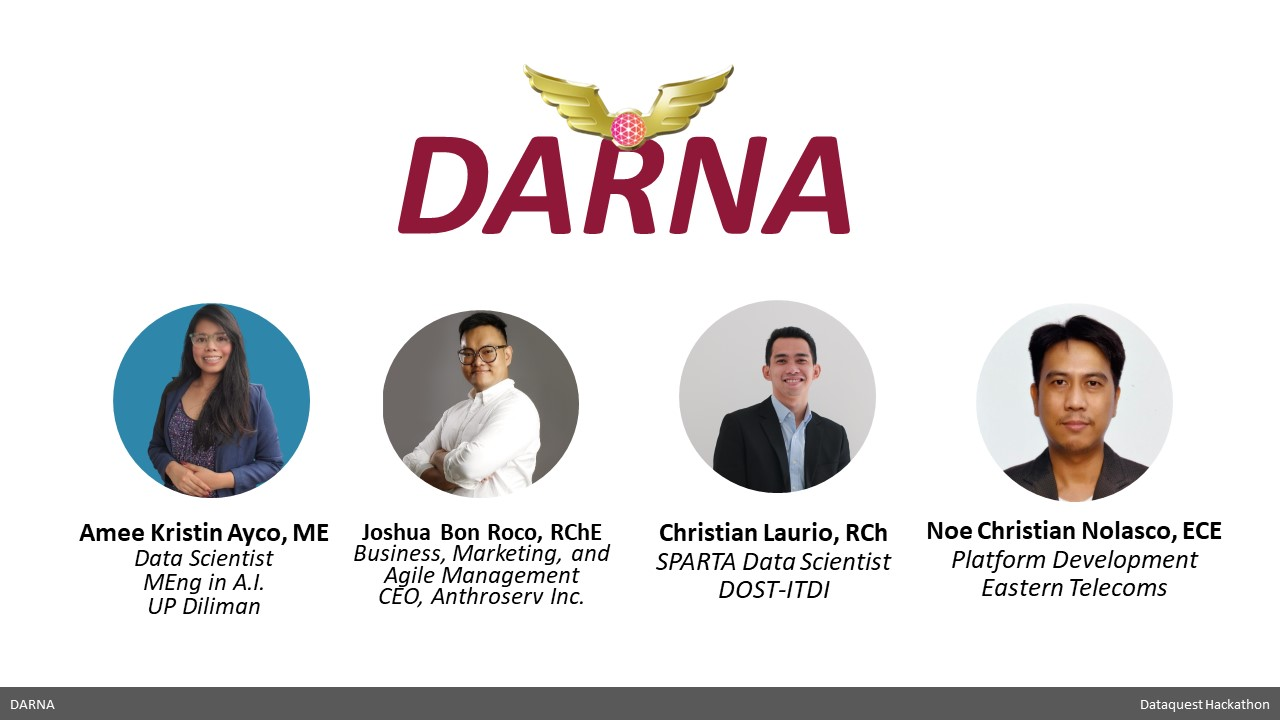